In [12]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

### Uzupełnianie  yes yes no no za pomoca tej zasady

In [4]:
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

In [5]:
cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne

train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)

### Zmiana typu kolumn numerycznych na INT64

In [6]:
cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         18524 non-null  int64 
 1   Time_spent_Alone           17334 non-null  Int64 
 2   Stage_fear                 18524 non-null  object
 3   Social_event_attendance    17344 non-null  Int64 
 4   Going_outside              17058 non-null  Int64 
 5   Drained_after_socializing  18524 non-null  object
 6   Friends_circle_size        17470 non-null  Int64 
 7   Post_frequency             17260 non-null  Int64 
 8   Personality                18524 non-null  object
dtypes: Int64(5), int64(1), object(3)
memory usage: 1.4+ MB


## CATBOOST

In [7]:
X=train_df.drop(['id','Personality'], axis=1).copy()
y=train_df['Personality'].copy()

In [27]:


cat_features = ['Stage_fear','Drained_after_socializing']
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)
model = CatBoostClassifier(verbose=0, cat_features=cat_features,)  # verbose=0 żeby nie spamował

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [0.01, 0.03],#, 0.05, 0.1],
    # 'depth': [ 6],#, 8],
    # 'l2_leaf_reg': [1],#, 3],
     'iterations': [200, 1000]
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=5,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','params']]

Najlepsze parametry: {'iterations': 200, 'learning_rate': 0.03}
Najlepszy wynik: 0.9690134165784954


,rank_test_score,mean_test_score,params
0,2,0.968851,"{'iterations': 200, 'learning_rate': 0.01}"
1,1,0.969013,"{'iterations': 200, 'learning_rate': 0.03}"
2,3,0.968582,"{'iterations': 1000, 'learning_rate': 0.01}"
3,4,0.968258,"{'iterations': 1000, 'learning_rate': 0.03}"


<Figure size 1000x600 with 0 Axes>

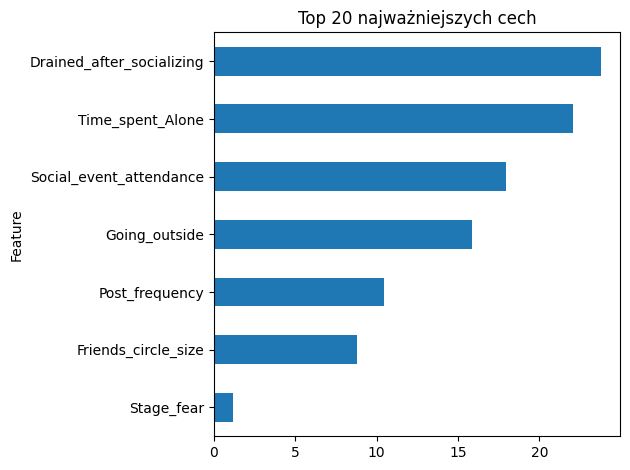

In [28]:

# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(20).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

## Optuna

In [ ]:
import optuna
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "iterations": 500,
        "verbose": 0,
        "loss_function": "Logloss"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_valid)[:,1]
    return roc_auc_score(y_valid, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params